# Прогнозирование стоимости автомобиля по характеристикам

В рамках соревнования на Kaggle необходимо предсказать стоимость автомобиля, используя различные модели ML и DL; данные с характеристиками и изображениями предоставлены на платформе.


## Задачи проекта:
* Построить "наивную" модель, предсказывающую цену по модели и году выпуска для определения начальной метрики(с ней будем сравнивать другие модели)
* Обработать и нормализовать признаки для различных моделей
* Сделать модель на основе градиентного бустинга с помощью CatBoost
* Сделать модель на основе нейронных сетей 
* Сделать multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавить в multi-input сеть обработку изображений
* Осуществить ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)
* Осуществить проброс значимого признака

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# для лемматизации
!pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 8.2 MB 3.8 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
!pip install -U pymorphy2-dicts-ru

Requirement already up-to-date: pymorphy2-dicts-ru in /opt/conda/lib/python3.7/site-packages (2.4.417127.4579844)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import string
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# nltk
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords, words
from nltk.stem.snowball import RussianStemmer
from nltk.util import ngrams
from tqdm import tqdm


# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline



# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

# SUBMISSION
VERSION = 1

In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [8]:
!pip freeze > requirements.txt

## Предобработка

In [9]:
# метрика в виде функции
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [10]:
# функция распределения числовых признаков

def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

In [11]:
# функция, показывающая распределение данных
def column_info(column):
    print('Информация о столбце {}'.format(column))
    print(f'Количество пустых строк: {data[column].isnull().sum()}')
    print('Распределение столбца:', pd.DataFrame(data[column].value_counts()))
    print(data[column].describe())
    if data[column].dtype == 'int64' or data[column].dtype == 'float64':
        median = data[column].median()
        perc25 = data[column].quantile(0.25)
        perc75 = data[column].quantile(0.75)
        IQR = perc75 - perc25
        print(
            f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR} Границы выбросов: [{perc25 - 1.5*IQR},{perc75 + 1.5*IQR}]')
        data[column].hist(bins=10, label='IQR')
        plt.legend()
    print('\n')

In [12]:
# функция для токенизации
def text_tokenizer(text):
    Text_ = text.strip()

    Text_ = Text_.lower()

    # Удалим все спец символы
    Text_ = remove_chars_from_text(Text_, spec_chars)

    # Удалим все цифры
    Text_ = remove_chars_from_text(Text_, string.digits)

    Text_ = Text_.replace('\n',' ').replace('\t',' ')

    # Токенизируем текст
    tokens = word_tokenize(Text_)

    # Список токенов преобразовываем к классу Text
    token_text = nltk.Text(tokens)

    # Удаляем стоп-слова
    filtered_token_text = [w for w in token_text if not w in english_stopwords]
    
    return filtered_token_text

In [13]:
# функция отображения метрики модели
def print_learn_report(start, y_test, y_pred):
    print('\nВремя выполнения - ', datetime.now() - start)
    print(f"Точность по метрике MAPE:{(mape(y_test, y_pred))*100:0.2f}%")

In [ ]:
# функция для удаления спец символов
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [14]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [16]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [17]:
# переименуем столбцы в датасетах, чтобы они соответствовали друг другу
columns_rename={
            'bodyType': 'body_type',
            'engineDisplacement': 'engine_displacement',
            'enginePower': 'engine_power',
            'fuelType': 'fuel_type',
            'modelDate': 'model_date',
            'numberOfDoors': 'number_doors',
            'productionDate': 'production_date',
            'vehicleConfiguration': 'configuration',
            'vehicleTransmission': 'transmission',
            'Владельцы': 'car_owners',
            'Владение': 'ownership',
            'ПТС': 'pts',
            'Привод': 'drive_type',
            'Руль': 'wheel'
        }

test = test.rename(columns=columns_rename)
train = train.rename(columns=columns_rename)

In [18]:
# проверяем изменения
train.columns, test.columns

(Index(['body_type', 'brand', 'color', 'description', 'engine_displacement',
        'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info',
        'name', 'number_doors', 'price', 'production_date', 'sell_id',
        'configuration', 'transmission', 'car_owners', 'ownership', 'pts',
        'drive_type', 'wheel'],
       dtype='object'),
 Index(['body_type', 'brand', 'color', 'description', 'engine_displacement',
        'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info',
        'name', 'number_doors', 'production_date', 'sell_id', 'configuration',
        'transmission', 'car_owners', 'ownership', 'pts', 'drive_type',
        'wheel'],
       dtype='object'))

In [ ]:
# используем pandas profiling для оценки датасетов
pandas_profiling.ProfileReport(train, title="Pandas Profiling Report")

Из первоначального отчета видно, что пропуски в 2х признаках: 'car_owners' и 'ownership, что есть признаки, сильно коррелирующие между собой, дубликатов нет.

In [ ]:
# выводим результаты в виде отчета
pandas_profiling.ProfileReport(test, title="Pandas Profiling Report")

В тесте отсутствует только таргет 'price', пропуски только в признаке 'car_owners', также есть сильная корреляция признаков. После построения наивной модели проведем более детальный анализ данных на объединенном датасете.

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [19]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [20]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'production_date']]).iterrows():
    query = f"model_info == '{row[0]}' and production_date == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


Вывод: результат работы моих моделей по метрике MAPE должен быть лучше 19.88%.

# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

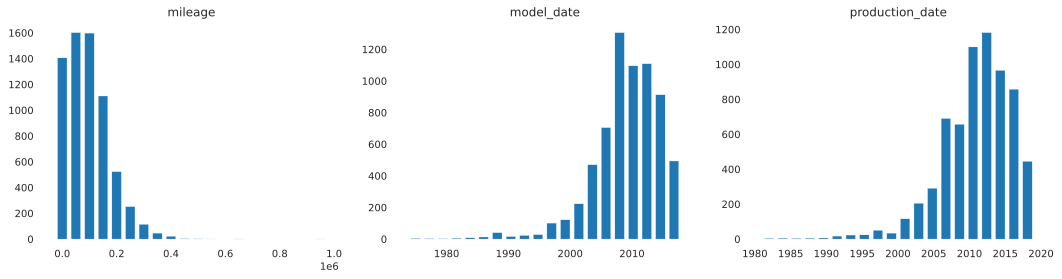

In [21]:
visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'model_date': train['model_date'].dropna(),
    'production_date': train['production_date'].dropna()
})

Распределение нужно нормализовать.

In [22]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


1. Работа с пропусками

In [23]:
# посмотрим на пропуски по столбцам
data.isnull().sum().sort_values(ascending=False)

ownership              5418
car_owners                1
price                     0
model_info                0
brand                     0
color                     0
description               0
engine_displacement       0
engine_power              0
fuel_type                 0
mileage                   0
model_date                0
number_doors              0
name                      0
sample                    0
production_date           0
sell_id                   0
configuration             0
transmission              0
pts                       0
drive_type                0
wheel                     0
body_type                 0
dtype: int64

Заполним пропуск в столбце 'car_owners', так как информация о владельцах отсутствует, будем считать, что у машины был/есть хотя бы один владелец.

In [24]:
# заполняем пропуск единицей
data['car_owners'] = data['car_owners'].fillna('1').apply(lambda x: x.split()[0]).astype('int32')

In [ ]:
data['car_owners'] = data['car_owners'].apply(lambda x: 1 if x == '1\xa0владелец' 
                                            else 2 if x == '2\xa0владельца' else 3)

В столбце 'ownership' отсутствует большой массив данных

In [ ]:
data['ownership'].value_counts()

In [ ]:
# я  пыталась заполнить пропуски, но результат модели был хуже, чем в случае удаления столбца.
#data.ownership=data.ownership.fillna('0')
#data.ownership=data.ownership.apply(lambda x: x.replace('лет', '* 12'))
#data.ownership=data.ownership.apply(lambda x: x.replace('года', '* 12'))
#data.ownership=data.ownership.apply(lambda x: x.replace('год', '* 12'))
#data.ownership=data.ownership.apply(lambda x: x.replace('и', '+'))
#data.ownership=data.ownership.apply(lambda x: x.replace('месяца', ''))
#data.ownership=data.ownership.apply(lambda x: x.replace('месяцев', ''))
#data.ownership=data.ownership.apply(lambda x: x.replace('месяц', ''))
#data.ownership=data.ownership.apply(lambda x: x.replace(' ', ''))
#data.ownership=data.ownership.apply(lambda x: eval(x))
#data.ownership.unique()

In [25]:
data = data.drop(['ownership'], axis=1)

In [27]:
column_info('body_type')

Информация о столбце body_type
Количество пустых строк: 0
Распределение столбца:                       body_type
седан                      3541
внедорожник 5 дв.          2896
купе                        543
хэтчбек 5 дв.               364
лифтбек                     299
универсал 5 дв.             196
минивэн                     178
купе-хардтоп                111
родстер                      88
хэтчбек 3 дв.                57
кабриолет                    54
компактвэн                    8
внедорожник 3 дв.             5
лимузин                       5
внедорожник открытый          4
пикап двойная кабина          3
седан 2 дв.                   1
count      8353
unique       17
top       седан
freq       3541
Name: body_type, dtype: object




In [28]:
column_info('brand')

Информация о столбце brand
Количество пустых строк: 0
Распределение столбца:           brand
BMW        3535
MERCEDES   2846
AUDI       1972
count     8353
unique       3
top        BMW
freq      3535
Name: brand, dtype: object




In [29]:
column_info('color')

Информация о столбце color
Количество пустых строк: 0
Распределение столбца:              color
чёрный        3468
белый         1607
серый          925
синий          863
серебристый    420
коричневый     386
красный        266
голубой         91
зелёный         86
бежевый         85
фиолетовый      46
пурпурный       38
оранжевый       30
золотистый      24
жёлтый          17
розовый          1
count       8353
unique        16
top       чёрный
freq        3468
Name: color, dtype: object




In [30]:
# формируем список из популярных цветов, остальное обозначим как "other"

color_list = ['чёрный', 'белый', 'серый', 'серебристый', 'синий']

data['popular_color'] = np.where(data['color'].isin(
    color_list), data['color'], 'other')

In [31]:
column_info('description')

Информация о столбце description
Количество пустых строк: 0
Распределение столбца:                                                     description
Выгода до 82 000 руб. при обмене на Ваш автомоб...          105
• Автомобиль проверен по 110 пунктам\n• Автокре...           84
РОЛЬФ - Официальный дилер и Лучший дилер России...           76
РОЛЬФ Премиум – крупнейший официальный дилер Мо...           75
Автодилер года 2020\n\nПобедитель в номинации «...           64
...                                                         ...
Автомобиль в хорошем состоянии , есть недочеты ...            1
Авто в отличном техническом состоянии, все ТО п...            1
Год выпуска: 2012. Пробег: 190 000 км. Кузов: в...            1
Автомобиль в идеальном состоянии. Безаварийный....            1
Автомобиль в отличном состоянии. Американец. по...            1

[7654 rows x 1 columns]
count                                                  8353
unique                                                 7654
top 

In [32]:
# смотрим на самые частые слова в описании
text = ' '.join(data['description'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(50)
my_list[:20]

[(('', '', '', '', ''), 9947),
 (('-', '-', '-', '-', '-'), 1000),
 (('6', '000', 'проверенных', 'автомобилей', 'с'), 630),
 (('000', 'проверенных', 'автомобилей', 'с', 'пробегом'), 630),
 (('проверенных', 'автомобилей', 'с', 'пробегом', 'с'), 630),
 (('автомобилей', 'с', 'пробегом', 'с', 'гарантией'), 630),
 (('с', 'пробегом', 'с', 'гарантией', 'до'), 630),
 (('пробегом', 'с', 'гарантией', 'до', '2'), 630),
 (('с', 'гарантией', 'до', '2', 'лет'), 630),
 (('гарантией', 'до', '2', 'лет', 'ждут'), 630),
 (('до', '2', 'лет', 'ждут', 'Вас'), 630),
 (('2', 'лет', 'ждут', 'Вас', 'на'), 630),
 (('лет', 'ждут', 'Вас', 'на', 'сайте'), 630),
 (('ждут', 'Вас', 'на', 'сайте', 'rolf-probeg'), 630),
 (('Вас', 'на', 'сайте', 'rolf-probeg', 'и'), 630),
 (('на', 'сайте', 'rolf-probeg', 'и', 'в'), 630),
 (('сайте', 'rolf-probeg', 'и', 'в', 'мобильном'), 630),
 (('rolf-probeg', 'и', 'в', 'мобильном', 'приложении'), 630),
 (('и', 'в', 'мобильном', 'приложении', 'Мой'), 630),
 (('в', 'мобильном', 'приложен

In [33]:
column_info('engine_displacement')

Информация о столбце engine_displacement
Количество пустых строк: 0
Распределение столбца:                engine_displacement
2.0 LTR                       2430
3.0 LTR                       2349
1.8 LTR                        411
1.6 LTR                        410
4.4 LTR                        329
5.5 LTR                        268
3.5 LTR                        250
2.5 LTR                        248
2.1 LTR                        221
4.0 LTR                        153
4.7 LTR                        137
1.4 LTR                        106
2.8 LTR                        106
4.2 LTR                        103
5.0 LTR                         74
1.5 LTR                         73
3.2 LTR                         60
2.2 LTR                         58
4.8 LTR                         57
2.9 LTR                         50
2.4 LTR                         44
3.1 LTR                         44
6.2 LTR                         40
6.0 LTR                         37
1.2 LTR                         33

In [34]:
# преобразуем формат значения
data['engine_displacement'] = data['engine_displacement'].apply(
    lambda x: x[:3])

# заменим LT на наиболее частое 2.0
data['engine_displacement'] = data['engine_displacement'].apply(
    lambda x: 2.0 if x == ' LT' else x)

In [35]:
data['engine_displacement'] = data['engine_displacement'].replace('und', 2.0)

data['engine_displacement']=data['engine_displacement'].astype('float').round(1)

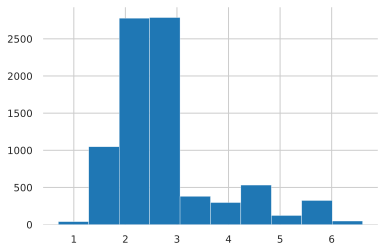

In [36]:
data['engine_displacement'].hist()

In [37]:
# нормализуем данные
data['engine_displacement'] = np.log(data['engine_displacement'] + 1)

In [38]:
column_info('engine_power')

Информация о столбце engine_power
Количество пустых строк: 0
Распределение столбца:          engine_power
184 N12           759
249 N12           655
190 N12           420
245 N12           355
306 N12           344
...               ...
591 N12             1
480 N12             1
132 N12             1
457 N12             1
166 N12             1

[154 rows x 1 columns]
count        8353
unique        154
top       184 N12
freq          759
Name: engine_power, dtype: object




In [39]:
# преобразуем формат значения
data['engine_power'] = data['engine_power'].apply(lambda x: x[:3])

data['engine_power']=data['engine_power'].astype('float').round(1)

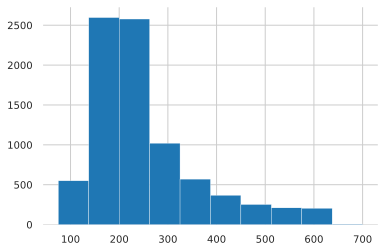

In [40]:
data['engine_power'].hist()

In [41]:
#нормализуем данные
data['engine_power'] = np.log(data['engine_power'] + 1)

In [42]:
column_info('fuel_type')

Информация о столбце fuel_type
Количество пустых строк: 0
Распределение столбца:          fuel_type
бензин        6018
дизель        2315
гибрид          14
электро          6
count       8353
unique         4
top       бензин
freq        6018
Name: fuel_type, dtype: object




Информация о столбце mileage
Количество пустых строк: 0
Распределение столбца:         mileage
120000       79
150000       79
180000       77
130000       70
140000       62
...         ...
107800        1
80250         1
373           1
41329         1
102402        1

[3507 rows x 1 columns]
count       8353.000000
mean      120362.983479
std        81856.639133
min            1.000000
25%        59246.000000
50%       110384.000000
75%       167084.000000
max      1000000.000000
Name: mileage, dtype: float64
25-й перцентиль: 59246.0, 75-й перцентиль: 167084.0, IQR: 107838.0 Границы выбросов: [-102511.0,328841.0]




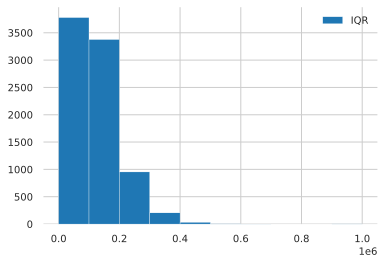

In [43]:
column_info('mileage')

Информация о столбце model_date
Количество пустых строк: 0
Распределение столбца:       model_date
2011         830
2013         739
2014         667
2015         656
2009         655
2008         562
2012         548
2007         542
2016         467
2010         407
2006         345
2005         321
2017         298
2004         242
2018         234
2003         146
2002         135
2019          82
2000          80
2001          76
1999          58
1998          56
1990          48
1994          31
1995          25
1997          16
1996          15
1992          14
1987          11
1984          10
1985           7
1989           5
1982           5
1979           4
1991           4
1977           2
1981           2
1975           2
1988           2
1993           1
1986           1
1971           1
1976           1
count    8353.000000
mean     2010.103556
std         5.436914
min      1971.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Na

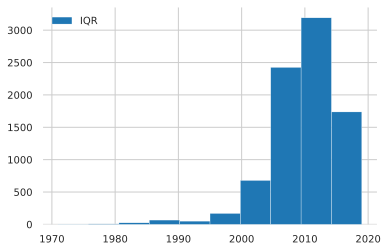

In [44]:
column_info('model_date')

In [45]:
# приведем у удобному формату
data['model_date'] = data['model_date'].astype('int64')

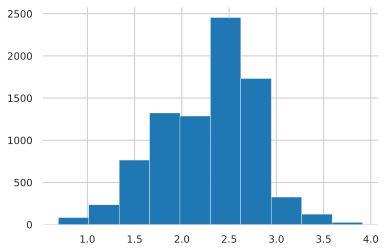

In [46]:
# нормализуем данные
data['model_date'] = np.log(2021 - data['model_date'])
data['model_date'].hist()

In [47]:
column_info('model_info')

Информация о столбце model_info
Количество пустых строк: 0
Распределение столбца:                 model_info
5ER                    776
3ER                    578
X5                     501
E_KLASSE               490
A6                     433
...                    ...
Z3M                      1
SLC_KLASSE_AMG           1
100                      1
W123                     1
None                     1

[122 rows x 1 columns]
count     8353
unique     122
top        5ER
freq       776
Name: model_info, dtype: object




In [48]:
column_info('name')

Информация о столбце name
Количество пустых строк: 0
Распределение столбца:                             name
35i 3.0 AT (306 л.с.) 4WD    151
2.0 AMT (211 л.с.) 4WD       145
200 2.0 AT (184 л.с.)        137
30d 3.0d AT (249 л.с.) 4WD   109
400 3.0 AT (333 л.с.) 4WD     97
...                          ...
350 3.7 AT (245 л.с.)          1
L1 3.2 AT (190 л.с.)           1
L2 3.7 AT (231 л.с.)           1
180 1.6 MT (122 л.с.)          1
220 2.2d AT (170 л.с.)         1

[976 rows x 1 columns]
count                          8353
unique                          976
top       35i 3.0 AT (306 л.с.) 4WD
freq                            151
Name: name, dtype: object




Информация о столбце number_doors
Количество пустых строк: 0
Распределение столбца:    number_doors
5          3854
4          3636
2           802
3            61
count    8353.000000
mean        4.262062
std         0.885531
min         2.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: number_doors, dtype: float64
25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0 Границы выбросов: [2.5,6.5]




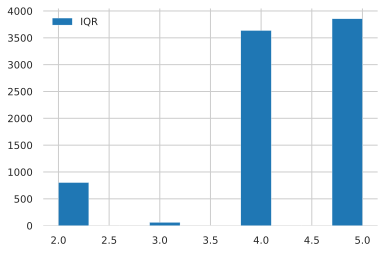

In [49]:
column_info('number_doors')

Информация о столбце production_date
Количество пустых строк: 0
Распределение столбца:       production_date
2013              783
2011              702
2014              693
2012              680
2016              600
2015              599
2017              562
2018              529
2008              510
2010              468
2019              449
2009              345
2007              343
2006              182
2005              170
2004              155
2020              100
2003              100
2002               78
2001               73
1999               45
2000               43
1998               24
1997               21
1994               15
1995               14
1992               12
1996               12
1993               12
1990               10
1985                4
1986                4
1988                4
1982                3
1984                3
1991                2
1983                2
1989                1
1987                1
count    8353.000000
mean     201

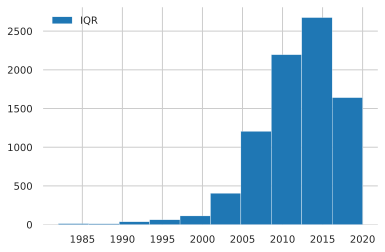

In [50]:
column_info('production_date')

In [51]:
# приведем у удобному формату
data['production_date'] = data['production_date'].astype('int64')

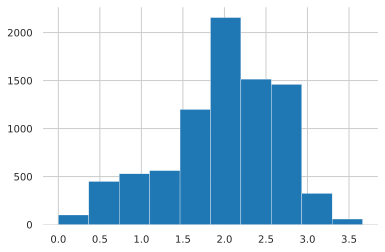

In [52]:
# нормализуем данные
data['production_date'] = np.log(2021 - data['production_date'])
data['production_date'].hist()

Информация о столбце sell_id
Количество пустых строк: 0
Распределение столбца:             sell_id
1099612970        1
1055208716        1
1099093264        1
1098720534        1
1099863320        1
...             ...
1100249730        1
1084457605        1
1099623048        1
1099300402        1
1097908224        1

[8353 rows x 1 columns]
count    8.353000e+03
mean     1.096591e+09
std      2.657545e+07
min      3.421294e+07
25%      1.097086e+09
50%      1.099407e+09
75%      1.099975e+09
max      1.100273e+09
Name: sell_id, dtype: float64
25-й перцентиль: 1097085896.0, 75-й перцентиль: 1099975262.0, IQR: 2889366.0 Границы выбросов: [1092751847.0,1104309311.0]




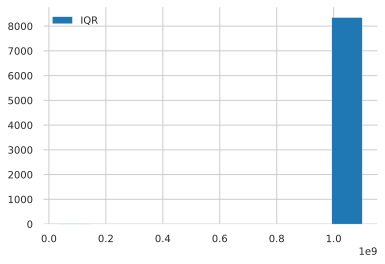

In [53]:
column_info('sell_id')

In [54]:
column_info('configuration')

Информация о столбце configuration
Количество пустых строк: 0
Распределение столбца:                                configuration
ALLROAD_5_DOORS AUTOMATIC 3.0           1292
SEDAN AUTOMATIC 2.0                      941
SEDAN AUTOMATIC 3.0                      631
ALLROAD_5_DOORS AUTOMATIC 2.0            524
ALLROAD_5_DOORS ROBOT 2.0                226
...                                      ...
CABRIO AUTOMATIC 1.8                       1
SEDAN MECHANICAL 4.2                       1
WAGON_5_DOORS AUTOMATIC 4.7                1
COUPE AUTOMATIC 2.3                        1
WAGON_5_DOORS AUTOMATIC 1.6                1

[312 rows x 1 columns]
count                              8353
unique                              312
top       ALLROAD_5_DOORS AUTOMATIC 3.0
freq                               1292
Name: configuration, dtype: object




In [55]:
# почистим признак 'configuration'
english_stopwords = stopwords.words("english") + ['лс','квт']
spec_chars = string.punctuation + '«»—…’‘”“©' 

# Зададим функцию для удаления спец символов
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

In [56]:
data['configuration'].apply(lambda x: text_tokenizer(x))

0       [wagondoors, automatic]
1            [coupe, automatic]
2            [coupe, automatic]
3            [sedan, automatic]
4            [sedan, automatic]
                 ...           
8348         [sedan, automatic]
8349         [sedan, automatic]
8350         [sedan, automatic]
8351         [sedan, automatic]
8352     [limousine, automatic]
Name: configuration, Length: 8353, dtype: object

In [57]:
dummies_configuration = data['configuration'].apply(lambda x: str(x).replace('[','').
                                                       replace(']','')).str.get_dummies(sep=', ').reset_index(drop=True)

In [58]:
column_info('transmission')

Информация о столбце transmission
Количество пустых строк: 0
Распределение столбца:                   transmission
автоматическая            6560
роботизированная          1201
вариатор                   406
механическая               186
count               8353
unique                 4
top       автоматическая
freq                6560
Name: transmission, dtype: object




In [ ]:
# подготовим признак для последующей обработки  
transmission_dict = {'автоматическая':' AT', 'вариатор':' CVT', 'механическая':' MT', 'роботизированная':' AMT'}
data['transmission'] = data['transmission'].replace(to_replace=transmission_dict)  

In [59]:
column_info('car_owners')

Информация о столбце car_owners
Количество пустых строк: 0
Распределение столбца:    car_owners
3        3311
1        2527
2        2515
count    8353.000000
mean        2.093858
std         0.830773
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: car_owners, dtype: float64




In [60]:
column_info('pts')

Информация о столбце pts
Количество пустых строк: 0
Распределение столбца:            pts
Оригинал  7474
Дубликат   879
count         8353
unique           2
top       Оригинал
freq          7474
Name: pts, dtype: object




In [61]:
column_info('drive_type')

Информация о столбце drive_type
Количество пустых строк: 0
Распределение столбца:           drive_type
полный          5218
задний          2259
передний         876
count       8353
unique         3
top       полный
freq        5218
Name: drive_type, dtype: object




In [62]:
column_info('wheel')

Информация о столбце wheel
Количество пустых строк: 0
Распределение столбца:         wheel
Левый    8351
Правый      2
count      8353
unique        2
top       Левый
freq       8351
Name: wheel, dtype: object




In [ ]:
# ухудшает результат
#data['wheel'] = data['wheel'].map(lambda x:1 if x=='Левый' else 0 ) 

Информация о столбце price
Количество пустых строк: 0
Распределение столбца:             price
0.0          1671
950000.0       76
1100000.0      73
1200000.0      71
850000.0       68
...           ...
3195000.0       1
685850.0        1
13498000.0      1
1294000.0       1
1594000.0       1

[1629 rows x 1 columns]
count    8.353000e+03
mean     1.519804e+06
std      1.873130e+06
min      0.000000e+00
25%      4.600000e+05
50%      1.030000e+06
75%      1.900000e+06
max      2.390000e+07
Name: price, dtype: float64
25-й перцентиль: 460000.0, 75-й перцентиль: 1900000.0, IQR: 1440000.0 Границы выбросов: [-1700000.0,4060000.0]




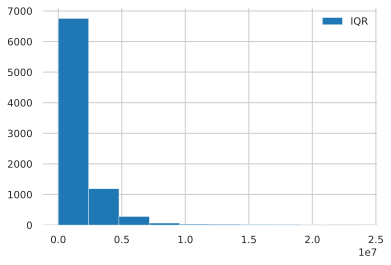

In [63]:
column_info('price')

Распределение таргета ненормальное, позже прологарифмируем его.

## Генерация новых признаков

In [64]:
#  создадим новый признак - самый популярный цвет -1, остальное - 0
data['popular_color'] = data.color.apply(lambda x: 1 if x in color_list else 0)

In [ ]:
# создадим признаки на основе часто встречающихся слов в описании
data['rolf'] = data.description.apply(lambda x: 1 if 'РОЛЬФ' in x else 0)
data['dealer'] = data.description.apply(lambda x: 1 if 'дилер' in x else 0)
data['airbag'] = data.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)
data['warranty'] = data.description.apply(lambda x: 1 if 'гарантия' in x else 0)
data['child_car_seat'] = data.description.apply(lambda x: 1 if 'крепления детских автокресел' in x else 0)
data['seat_heating'] = data.description.apply(lambda x: 1 if 'подогрев сидений' in x else 0)
data['power_windows'] = data.description.apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)
data['central_lock'] = data.description.apply(lambda x: 1 if 'центральный замок' in x else 0)
data['computer'] = data.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)

In [65]:
# лучшая корреляция с 'price', если брать mileage в степени 0.5
data['mileage'] = data['mileage']**(0.5)

In [66]:
#добавим новые признаки
data['4wd'] = data['name'].apply(lambda x: 1 if '4WD' in x else 0)
data['xdrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)

In [67]:
# пробовала добавть признаки ниже, но они ухудшали результат из-за сильной 
# корреляции с другими признаками
# пробег / кол-во владельцев (сколько владелец в среднем проезжал на авто)
#data['mileage_owner'] = data['mileage'] / data['car_owners']
#data['mileage_owner'] = data['mileage_owner'].astype('int64')

# возраст автомобиля
#data['car_age'] = data['production_date'].apply(lambda x: pd.Timestamp.today().year - x)
    
# пробег в зависимости от возраста
#data['mile_per_year'] = data['mileage'] / data['car_age']

In [68]:
# мощность на объем двигателя
data['power_per_volume'] = data['engine_power']/data['engine_displacement']

In [69]:
print('Размерность финального датасета:', data.shape)
data.head(2)

Размерность финального датасета: (8353, 26)


,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_date,model_info,name,number_doors,production_date,sell_id,configuration,transmission,car_owners,pts,drive_type,wheel,sample,price,popular_color,4wd,xdrive,power_per_volume
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,1.386294,5.398163,бензин,591.607978,3.610918,W124,300 3.0 AT (220 л.с.),5,3.401197,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3,Оригинал,задний,Левый,0,0.0,1,0,0,3.893951
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,1.386294,5.749393,дизель,122.474487,2.302585,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2.079442,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1,Оригинал,полный,Левый,0,0.0,1,1,1,4.147310


In [70]:
data.columns

Index(['body_type', 'brand', 'color', 'description', 'engine_displacement',
       'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info',
       'name', 'number_doors', 'production_date', 'sell_id', 'configuration',
       'transmission', 'car_owners', 'pts', 'drive_type', 'wheel', 'sample',
       'price', 'popular_color', '4wd', 'xdrive', 'power_per_volume'],
      dtype='object')

In [71]:
#обновляем список категориальных
categorical_features = [
    'body_type',
    'brand',
    'color',
    'model_info',
    'fuel_type',
    'number_doors',
    'transmission',
    'car_owners',
    'popular_color',
    'rolf',
    'dealer',
    'airbag',
    'warranty',
    'child_car_seat',
    'seat_heating',
    'power_windows',
    'central_lock',
    'computer',
    '4wd', 
    'xdrive',
    'wheel',
    'pts',
    'drive_type',
]

#обновляем список числовых признаков
numerical_features = [
    'engine_displacement',
    'engine_power',
    'mileage',
    'model_date',
    'production_date',
    'power_per_volume'
]


data.drop(['sell_id','description','configuration','name'], axis=1, inplace=True)

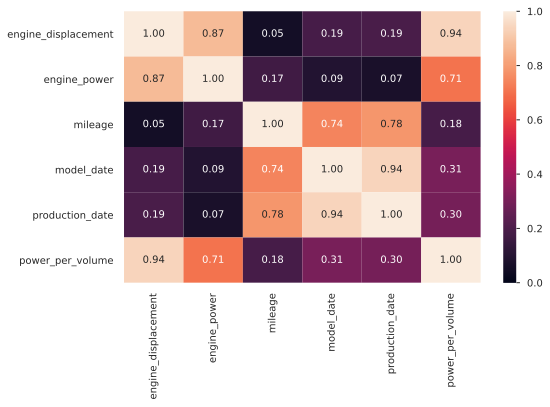

In [72]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(data[numerical_features].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

Есть сильная корреляция между 'model_date'и 'production_date', 'engine_displacement' и 'engine_power', но удалять их не будем

Text(0.5, 1.0, 'Значимость числовых признаков')

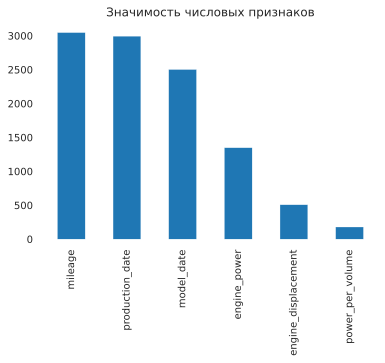

In [73]:
# используем дисперсионный анализ для определения значимости числовых признаков
imp_num = pd.Series(f_regression(
    data[numerical_features], data["price"])[0], index=numerical_features)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")
plt.title('Значимость числовых признаков')

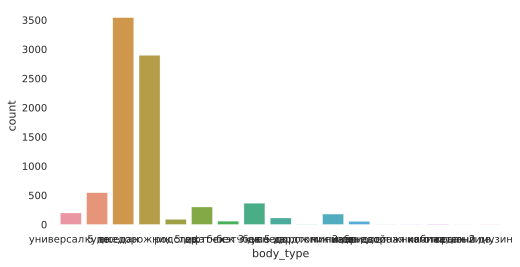

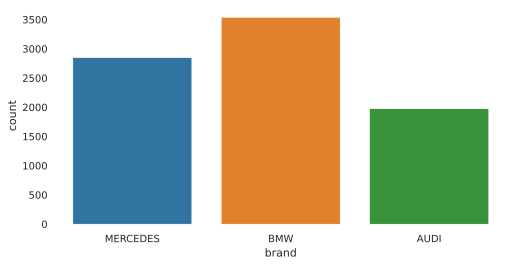

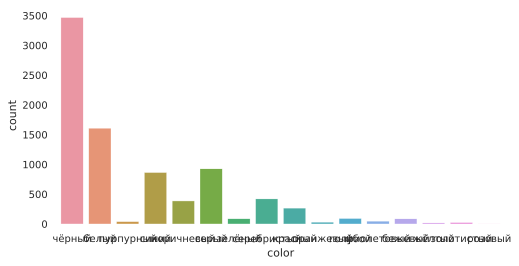

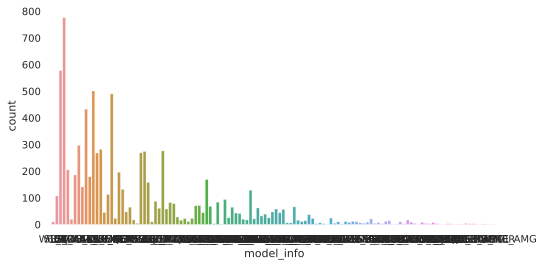

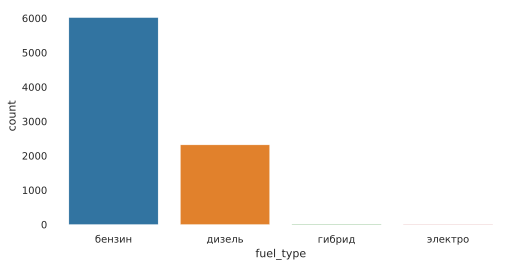

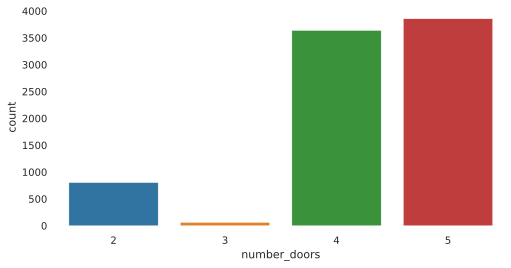

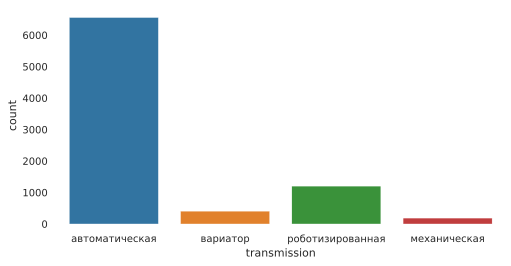

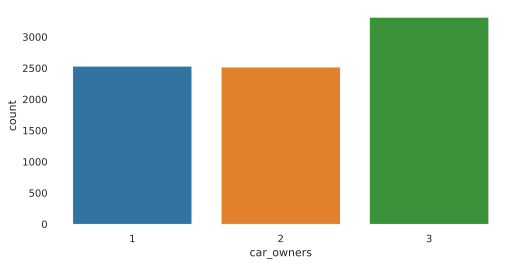

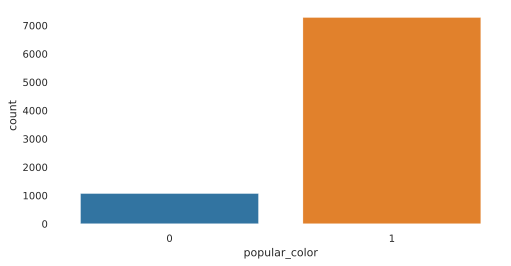

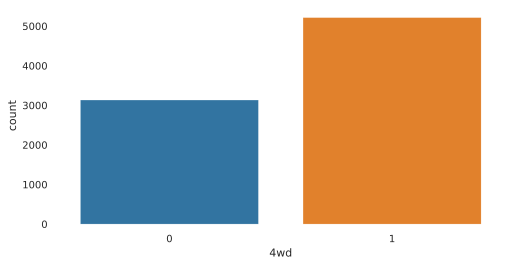

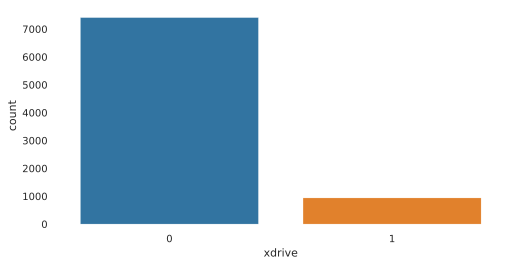

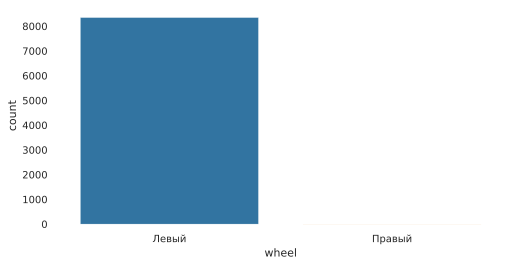

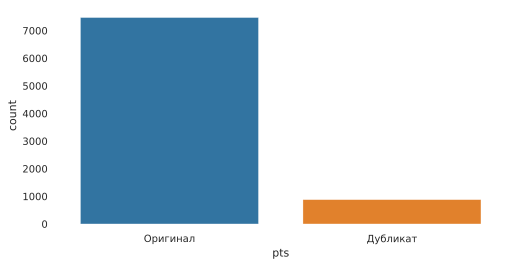

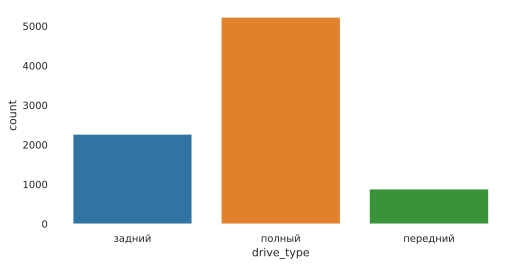

In [74]:
# смотрим на распределение категориальных признаков
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[feature])

In [75]:
#  кодируем категориальные признаки Label Encoding
for column in categorical_features:
    data[column] = data[column].astype('category').cat.codes

Text(0.5, 1.0, 'Значимость категориальных признаков')

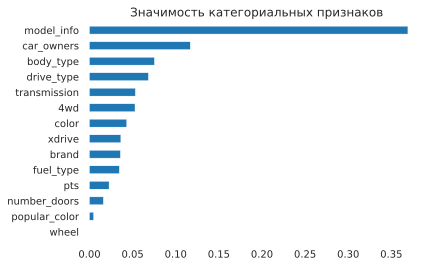

In [76]:
# определим значимость категориальных признаков
imp_cat = pd.Series(mutual_info_regression(pd.concat([data[categorical_features]], axis=1),
                                           data['price'], discrete_features=True),
                    index=pd.concat([data[categorical_features]], axis=1).columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Значимость категориальных признаков')

In [77]:
# удалим признаки с нулевой значимостью
data.drop(['wheel', 'computer', 'popular_color'], axis=1, inplace=True)

In [78]:
data.sample(2)

,body_type,brand,color,engine_displacement,engine_power,fuel_type,mileage,model_date,model_info,number_doors,production_date,transmission,car_owners,pts,drive_type,sample,price,popular_color,4wd,xdrive,power_per_volume
383,12,1,6,1.386294,5.556828,0,418.330013,2.484907,7,2,2.302585,0,1,1,0,0,0.0,0,0,0,4.008404
4267,1,1,6,1.686399,6.439350,0,4.472136,0.693147,114,3,0.000000,0,0,1,2,1,12900000.0,0,1,0,3.818403


# PreProc Tabular Data

In [79]:
# используем все текстовые признаки как категориальные 
categorical_features = [
    'body_type',
    'brand',
    'color',
    'model_info',
    'fuel_type',
    'number_doors',
    'transmission',
    'car_owners',
    'rolf', 
    'dealer', 
    'airbag', 
    'warranty',
    'child_car_seat', 
    'power_windows', 
    'seat_heating',
    'central_lock',
    '4wd', 
    'xdrive',
    'pts',
    'drive_type',
]

# обновляем список числовых признаков
numerical_features = [
    'engine_displacement',
    'engine_power',
    'mileage',
    'model_date',
    'production_date',
    'power_per_volume'
]

In [80]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ################################## 
    # переименуем название столбцов
    def col_change(df_input):
        df_output = df_input.copy()
        df_output = df_output.rename(
            columns={
                'bodyType': 'body_type',
                'engineDisplacement': 'engine_displacement',
                'enginePower': 'engine_power',
                'fuelType': 'fuel_type',
                'modelDate': 'model_date',
                'numberOfDoors': 'number_doors',
                'productionDate': 'production_date',
                'vehicleConfiguration': 'configuration',
                'vehicleTransmission': 'transmission',
                'Владельцы': 'car_owners',
                'Владение': 'ownership',
                'ПТС': 'pts',
                'Привод': 'drive_type',
                'Руль': 'wheel'
            })
        return df_output
    
    # убираем не нужные для модели признаки
    df_output.drop(['sell_id','ownership','wheel'], axis = 1, inplace=True)
    
    # ################### Numerical Features ################################
    
    # заполняем пропуск единицей
    df_output['car_owners'] = df_output['car_owners'].fillna(1)
    df_output['car_owners'] = df_output['car_owners'].apply(lambda x: 1 if x == '1\xa0владелец' 
                                            else 2 if x == '2\xa0владельца' else 3)
    
    # преобразуем формат значения
    
    df_output['engine_displacement'] = df_output['engine_displacement'].apply(lambda x: x[:3])
    # заменим LT на наиболее частое 2.0
    df_output['engine_displacement'] = df_output['engine_displacement'].apply(lambda x: 2.0 if x == ' LT' else x)
    df_output['engine_displacement'] = df_output['engine_displacement'].replace('und', 2.0)
    df_output['engine_displacement'] = df_output['engine_displacement'].astype('float').round(1)
    # преобразуем формат значения
    df_output['engine_power'] = df_output['engine_power'].apply(lambda x: x[:3])
    df_output['engine_power'] = df_output['engine_power'].astype('float').round(1)
    
    
    # переименуем значения столбца
    transmission_dict = {'автоматическая':' AT', 'вариатор':' CVT', 'механическая':' MT', 'роботизированная':' AMT'}
    df_output['transmission'] = df_output['transmission'].replace(to_replace=transmission_dict)
    
    # ################### Feature Engineering ####################################################
    
    # добавим новые признаки
    df_output['rolf'] = df_output['description'].apply(lambda x: 1 if 'РОЛЬФ' in x else 0)
    df_output['dealer'] = df_output['description'].apply(lambda x: 1 if 'дилер' in x else 0)
    df_output['airbag'] = df_output['description'].apply(lambda x: 1 if 'подушки безопасности' in x else 0)
    df_output['warranty'] = df_output['description'].apply(lambda x: 1 if 'гарантия' in x else 0)
    df_output['child_car_seat'] = df_output['description'].apply(lambda x: 1 if 'крепления детских автокресел' in x else 0)
    df_output['power_windows'] = df_output['description'].apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)
    df_output['central_lock'] = df_output['description'].apply(lambda x: 1 if 'центральный замок' in x else 0)
    df_output['seat_heating'] = df_output['description'].apply(lambda x: 1 if 'подогрев сидений' in x else 0)
    
    df_output['mileage'] = df_output['mileage']**(0.5) # Лучшая корреляция с price если брать mileage в сетпени 0.5  
    
    df_output['4wd'] = df_output['name'].apply(lambda x: 1 if '4WD' in x else 0)
    df_output['xdrive'] = df_output['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
    
    df_output['power_per_volume'] = df_output['engine_power']/df_output['engine_displacement'] 
    
    df_output['configuration'] = df_output['configuration'].apply(lambda x: text_tokenizer(x)) 
    dummies_configuration = data['configuration'].apply(lambda x: str(x).replace('[','').
                                                       replace(']','')).str.get_dummies(sep=', ').reset_index(drop=True)
    df_output = pd.concat([df_output, dummies_configuration], axis=1)  
    
    # Логарифмирование
    df_output['model_date'] = np.log(2021 - df_output['model_date'])
    df_output['production_date'] = np.log(2021 - df_output['production_date'])
    df_output['engine_power'] = np.log(df_output['engine_power'] + 1)
    df_output['engine_displacement'] = np.log(df_output['engine_displacement'] + 1)
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)
    
    # ################### Clean #######################################
    # убираем признаки которые не нужны более 
    df_output.drop(['configuration', 'name','description'], axis = 1, inplace=True) 
    
    return df_output

In [82]:
# запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engine_displacement,engine_power,mileage,model_date,production_date,sample,price,power_per_volume,ALLROAD_3_DOORS AUTOMATIC 3.0,ALLROAD_3_DOORS AUTOMATIC 3.2,ALLROAD_3_DOORS AUTOMATIC 3.5,ALLROAD_3_DOORS MECHANICAL 3.0,ALLROAD_5_DOORS AUTOMATIC 1.5,ALLROAD_5_DOORS AUTOMATIC 2.0,ALLROAD_5_DOORS AUTOMATIC 2.1,ALLROAD_5_DOORS AUTOMATIC 2.5,ALLROAD_5_DOORS AUTOMATIC 2.7,ALLROAD_5_DOORS AUTOMATIC 2.9,ALLROAD_5_DOORS AUTOMATIC 3.0,ALLROAD_5_DOORS AUTOMATIC 3.2,ALLROAD_5_DOORS AUTOMATIC 3.5,ALLROAD_5_DOORS AUTOMATIC 3.6,ALLROAD_5_DOORS AUTOMATIC 3.7,ALLROAD_5_DOORS AUTOMATIC 4.0,ALLROAD_5_DOORS AUTOMATIC 4.1,ALLROAD_5_DOORS AUTOMATIC 4.2,ALLROAD_5_DOORS AUTOMATIC 4.4,ALLROAD_5_DOORS AUTOMATIC 4.6,ALLROAD_5_DOORS AUTOMATIC 4.7,ALLROAD_5_DOORS AUTOMATIC 4.8,ALLROAD_5_DOORS AUTOMATIC 5.0,ALLROAD_5_DOORS AUTOMATIC 5.4,ALLROAD_5_DOORS AUTOMATIC 5.5,ALLROAD_5_DOORS AUTOMATIC 5.9,ALLROAD_5_DOORS AUTOMATIC 6.0,ALLROAD_5_DOORS AUTOMATIC 6.2,ALLROAD_5_DOORS MECHANICAL 2.0,ALLROAD_5_DOORS MECHANICAL 3.0,ALLROAD_5_DOORS ROBOT 1.4,ALLROAD_5_DOORS ROBOT 1.5,ALLROAD_5_DOORS ROBOT 1.6,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.1,ALLROAD_5_DOORS ROBOT 2.5,ALLROAD_5_DOORS ROBOT 3.0,ALLROAD_5_DOORS ROBOT 3.2,ALLROAD_OPEN AUTOMATIC 3.0,ALLROAD_OPEN AUTOMATIC 5.0,ALLROAD_OPEN AUTOMATIC 5.5,CABRIO AUTOMATIC 1.8,CABRIO AUTOMATIC 2.0,CABRIO AUTOMATIC 2.5,CABRIO AUTOMATIC 2.8,CABRIO AUTOMATIC 3.0,CABRIO AUTOMATIC 3.2,CABRIO AUTOMATIC 3.5,CABRIO AUTOMATIC 4.4,CABRIO AUTOMATIC 4.7,CABRIO AUTOMATIC 5.0,CABRIO AUTOMATIC 5.5,CABRIO MECHANICAL 1.8,CABRIO MECHANICAL 4.2,CABRIO MECHANICAL 4.9,CABRIO ROBOT 3.0,CABRIO ROBOT 4.0,CABRIO ROBOT 5.0,COMPACTVAN AUTOMATIC 1.5,COMPACTVAN AUTOMATIC 2.0,COMPACTVAN MECHANICAL 1.5,COMPACTVAN ROBOT 1.5,COUPE AUTOMATIC 1.5,COUPE AUTOMATIC 1.6,COUPE AUTOMATIC 1.8,COUPE AUTOMATIC 2.0,COUPE AUTOMATIC 2.3,COUPE AUTOMATIC 2.5,COUPE AUTOMATIC 2.9,COUPE AUTOMATIC 3.0,COUPE AUTOMATIC 3.2,COUPE AUTOMATIC 4.0,COUPE AUTOMATIC 4.2,COUPE AUTOMATIC 4.3,COUPE AUTOMATIC 4.4,COUPE AUTOMATIC 4.7,COUPE AUTOMATIC 4.8,COUPE AUTOMATIC 5.0,COUPE AUTOMATIC 5.4,COUPE AUTOMATIC 5.5,COUPE AUTOMATIC 5.6,COUPE MECHANICAL 1.8,COUPE MECHANICAL 1.9,COUPE MECHANICAL 2.0,COUPE MECHANICAL 2.3,COUPE MECHANICAL 2.5,COUPE MECHANICAL 2.8,COUPE MECHANICAL 3.0,COUPE MECHANICAL 3.2,COUPE MECHANICAL 3.4,COUPE MECHANICAL 4.0,COUPE MECHANICAL 4.2,COUPE MECHANICAL 4.4,COUPE ROBOT 2.0,COUPE ROBOT 3.0,COUPE ROBOT 3.2,COUPE ROBOT 4.0,COUPE ROBOT 4.2,COUPE ROBOT 4.4,COUPE ROBOT 5.0,COUPE ROBOT 5.2,COUPE ROBOT 6.2,COUPE VARIATOR 1.8,COUPE VARIATOR 2.0,COUPE VARIATOR 3.2,COUPE_HARDTOP AUTOMATIC 1.8,COUPE_HARDTOP AUTOMATIC 2.0,COUPE_HARDTOP AUTOMATIC 2.2,COUPE_HARDTOP AUTOMATIC 2.6,COUPE_HARDTOP AUTOMATIC 3.0,COUPE_HARDTOP AUTOMATIC 3.2,COUPE_HARDTOP AUTOMATIC 3.5,COUPE_HARDTOP AUTOMATIC 4.7,COUPE_HARDTOP AUTOMATIC 5.0,COUPE_HARDTOP AUTOMATIC 5.5,COUPE_HARDTOP AUTOMATIC 5.8,COUPE_HARDTOP AUTOMATIC 6.0,COUPE_HARDTOP AUTOMATIC 6.2,HATCHBACK_3_DOORS AUTOMATIC 1.6,HATCHBACK_3_DOORS AUTOMATIC 1.8,HATCHBACK_3_DOORS AUTOMATIC 2.0,HATCHBACK_3_DOORS AUTOMATIC 3.0,HATCHBACK_3_DOORS MECHANICAL 1.6,HATCHBACK_3_DOORS MECHANICAL 1.8,HATCHBACK_3_DOORS ROBOT 1.2,HATCHBACK_3_DOORS ROBOT 1.4,HATCHBACK_3_DOORS ROBOT 1.8,HATCHBACK_3_DOORS ROBOT 2.0,HATCHBACK_3_DOORS VARIATOR 1.7,HATCHBACK_5_DOORS AUTOMATIC,HATCHBACK_5_DOORS AUTOMATIC 0.7,HATCHBACK_5_DOORS AUTOMATIC 1.5,HATCHBACK_5_DOORS AUTOMATIC 1.6,HATCHBACK_5_DOORS AUTOMATIC 2.0,HATCHBACK_5_DOORS AUTOMATIC 3.0,HATCHBACK_5_DOORS MECHANICAL 1.4,HATCHBACK_5_DOORS MECHANICAL 1.5,HATCHBACK_5_DOORS MECHANICAL 1.6,HATCHBACK_5_DOORS MECHANICAL 2.0,HATCHBACK_5_DOORS ROBOT 1.2,HATCHBACK_5_DOORS ROBOT 1.3,HATCHBACK_5_DOORS ROBOT 1.4,HATCHBACK_5_DOORS ROBOT 1.5,HATCHBACK_5_DOORS ROBOT 1.6,HATCHBACK_5_DOORS ROBOT 1.8,HATCHBACK_5_DOORS ROBOT 1.9,HATCHBACK_5_DOORS ROBOT 2.0,HATCHBACK_5_DOORS ROBOT 2.1,HATCHBACK_5_DOORS ROBOT 2.5,HATCHBACK_5_DOORS VARIATOR 1.5,HATCHBACK_5_DOORS VARIATOR 1.7,HATCHBACK_5_DOORS VARIATOR 2.0,LIFTBACK AUTOMATIC 2.0,LIFTBACK AUTOM

In [83]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 504 entries, engine_displacement to drive_type_2
dtypes: float64(7), int64(313), uint8(184)
memory usage: 21.9 MB


Вывод: проведен детальный анализ и очистка признаков,признаки обрабатывала по-разному проверяла изменения; сгенерированы новые признаки( многие были удалены из-за сильной корреляции с уже имеющимися в датасете, модель переобучалась);
проведена оценка значимости признаков, удалены признаки с нулевой значимостью.
В 'description' и  'configuration' проведена очистка текста, удаление стоп-слов и спец символов, выявление часто встречающихся выражений; преобразованы значения в столбце 'transmission' для NLP; проведена нормализация и логарифмирование числовых признаков.

## Split data

In [84]:
# выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [85]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 503 entries, engine_displacement to drive_type_2
dtypes: float64(7), int64(312), uint8(184)
memory usage: 4.4 MB


# Model 2: CatBoostRegressor

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

Целевую переменную прологарифмируем, чтобы распрделение было более нормальным, это влияет на качество предсказаний регрессии.

In [87]:

model = CatBoostRegressor(iterations = 5000,
                          depth=10,
#                           learning_rate = 0.1,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.0418470	test: 0.0419036	best: 0.0419036 (0)	total: 104ms	remaining: 8m 37s
100:	learn: 0.0117538	test: 0.0117967	best: 0.0117967 (100)	total: 3.33s	remaining: 2m 41s
200:	learn: 0.0091525	test: 0.0094920	best: 0.0094920 (200)	total: 7.01s	remaining: 2m 47s
300:	learn: 0.0085086	test: 0.0090623	best: 0.0090623 (300)	total: 10.2s	remaining: 2m 39s
400:	learn: 0.0081150	test: 0.0087944	best: 0.0087944 (400)	total: 13.5s	remaining: 2m 34s
500:	learn: 0.0077577	test: 0.0085620	best: 0.0085620 (500)	total: 17.2s	remaining: 2m 34s
600:	learn: 0.0074275	test: 0.0083643	best: 0.0083643 (600)	total: 20.5s	remaining: 2m 30s
700:	learn: 0.0071522	test: 0.0082351	best: 0.0082351 (700)	total: 23.8s	remaining: 2m 26s
800:	learn: 0.0068824	test: 0.0081273	best: 0.0081272 (799)	total: 28.1s	remaining: 2m 27s
900:	learn: 0.0066851	test: 0.0080601	best: 0.0080595 (899)	total: 31.5s	remaining: 2m 23s
1000:	learn: 0.0064825	test: 0.0079990	best: 0.0079990 (999)	tot

In [88]:

test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.38%


### Submission

In [89]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

подбор гиперпараметров

In [90]:
start = datetime.now()
# подбираем гиперпараметры для моделей с лучшими показателями
model = CatBoostRegressor(iterations=50,
                          loss_function='MAPE',
                          metric_period=10)
# оптимальные параметры
grid = {
    'learning_rate': [0.1, 0.13, 0.14, 0.15],
    'depth': [10, 11, 12],
    'l2_leaf_reg': [7, 7.5, 8],
    'random_strength': [0.2, 0.3, 0.4]
}

grid_search_result = model.grid_search(grid, X=X_train, y=np.log(y_train), plot=False, verbose=False, cv=3)

grid_search_result['params']



bestTest = 0.01368188401
bestIteration = 49


bestTest = 0.01140702126
bestIteration = 49


bestTest = 0.01108390909
bestIteration = 49


bestTest = 0.01110124868
bestIteration = 49


bestTest = 0.01377158329
bestIteration = 49


bestTest = 0.01137460212
bestIteration = 49


bestTest = 0.01095935747
bestIteration = 49


bestTest = 0.0110944367
bestIteration = 49


bestTest = 0.01377279755
bestIteration = 49


bestTest = 0.01142768425
bestIteration = 49


bestTest = 0.01092881778
bestIteration = 49


bestTest = 0.01086373297
bestIteration = 49


bestTest = 0.01435734915
bestIteration = 49


bestTest = 0.01213050331
bestIteration = 49


bestTest = 0.01183348538
bestIteration = 49


bestTest = 0.01153790547
bestIteration = 49


bestTest = 0.01437238167
bestIteration = 49


bestTest = 0.01228145622
bestIteration = 49


bestTest = 0.01188779398
bestIteration = 49


bestTest = 0.01184198099
bestIteration = 49


bestTest = 0.01428704251
bestIteration = 49


bestTest = 0.01199357204
bestItera

{'depth': 11, 'l2_leaf_reg': 8, 'random_strength': 0.2, 'learning_rate': 0.15}

пробовала и с  такими параметрами optimal_parameters = {'depth': 10, 'l2_leaf_reg': 7.5, 'random_strength': 0.2, 'learning_rate': 0.15}

In [91]:
# обучаем модель с оптимальными гиперпараметрами
optimal_parameters = {
    'depth': 11,
    'l2_leaf_reg': 8,
    'random_strength': 0.2,
    'learning_rate': 0.15
}

model_opt = CatBoostRegressor().set_params(**optimal_parameters)
model_opt.fit(X_train, np.log(y_train), verbose=False)

model_opt.save_model('catboost_opt_model.model')
y_pred = np.exp(model_opt.predict(X_test))
print_learn_report(start, y_test, y_pred)


Время выполнения -  0:05:24.471049
Точность по метрике MAPE:11.61%


In [92]:
sub_predict_catboost_opt = np.exp(model_opt.predict(X_sub))
sample_submission['price'] = sub_predict_catboost_opt
sample_submission.to_csv('catboost_opt_submission.csv', index=False)

Вывод: протестирована модель CatBoostRegressor, заметное улучшение по сравнению с наивной моделью - Точность по метрике MAPE:11.38%, достигнуто с помощью обработки имеющихся и добавления новых признаков, обрабатывался логарифм от целевой переменной, а на предикте бралась экспанента.
Подбор гиперпараметров для CatBoostRegressor улучшения не дал, точность по метрике MAPE:11.61%.
Будем использовать результат CatBoostRegressor для блендинга моделей.

# Model 3: Tabular NN

Построим обычную сеть:

In [93]:
X_train.head(5)

,engine_displacement,engine_power,mileage,model_date,production_date,power_per_volume,ALLROAD_3_DOORS AUTOMATIC 3.0,ALLROAD_3_DOORS AUTOMATIC 3.2,ALLROAD_3_DOORS AUTOMATIC 3.5,ALLROAD_3_DOORS MECHANICAL 3.0,ALLROAD_5_DOORS AUTOMATIC 1.5,ALLROAD_5_DOORS AUTOMATIC 2.0,ALLROAD_5_DOORS AUTOMATIC 2.1,ALLROAD_5_DOORS AUTOMATIC 2.5,ALLROAD_5_DOORS AUTOMATIC 2.7,ALLROAD_5_DOORS AUTOMATIC 2.9,ALLROAD_5_DOORS AUTOMATIC 3.0,ALLROAD_5_DOORS AUTOMATIC 3.2,ALLROAD_5_DOORS AUTOMATIC 3.5,ALLROAD_5_DOORS AUTOMATIC 3.6,ALLROAD_5_DOORS AUTOMATIC 3.7,ALLROAD_5_DOORS AUTOMATIC 4.0,ALLROAD_5_DOORS AUTOMATIC 4.1,ALLROAD_5_DOORS AUTOMATIC 4.2,ALLROAD_5_DOORS AUTOMATIC 4.4,ALLROAD_5_DOORS AUTOMATIC 4.6,ALLROAD_5_DOORS AUTOMATIC 4.7,ALLROAD_5_DOORS AUTOMATIC 4.8,ALLROAD_5_DOORS AUTOMATIC 5.0,ALLROAD_5_DOORS AUTOMATIC 5.4,ALLROAD_5_DOORS AUTOMATIC 5.5,ALLROAD_5_DOORS AUTOMATIC 5.9,ALLROAD_5_DOORS AUTOMATIC 6.0,ALLROAD_5_DOORS AUTOMATIC 6.2,ALLROAD_5_DOORS MECHANICAL 2.0,ALLROAD_5_DOORS MECHANICAL 3.0,ALLROAD_5_DOORS ROBOT 1.4,ALLROAD_5_DOORS ROBOT 1.5,ALLROAD_5_DOORS ROBOT 1.6,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.1,ALLROAD_5_DOORS ROBOT 2.5,ALLROAD_5_DOORS ROBOT 3.0,ALLROAD_5_DOORS ROBOT 3.2,ALLROAD_OPEN AUTOMATIC 3.0,ALLROAD_OPEN AUTOMATIC 5.0,ALLROAD_OPEN AUTOMATIC 5.5,CABRIO AUTOMATIC 1.8,CABRIO AUTOMATIC 2.0,CABRIO AUTOMATIC 2.5,CABRIO AUTOMATIC 2.8,CABRIO AUTOMATIC 3.0,CABRIO AUTOMATIC 3.2,CABRIO AUTOMATIC 3.5,CABRIO AUTOMATIC 4.4,CABRIO AUTOMATIC 4.7,CABRIO AUTOMATIC 5.0,CABRIO AUTOMATIC 5.5,CABRIO MECHANICAL 1.8,CABRIO MECHANICAL 4.2,CABRIO MECHANICAL 4.9,CABRIO ROBOT 3.0,CABRIO ROBOT 4.0,CABRIO ROBOT 5.0,COMPACTVAN AUTOMATIC 1.5,COMPACTVAN AUTOMATIC 2.0,COMPACTVAN MECHANICAL 1.5,COMPACTVAN ROBOT 1.5,COUPE AUTOMATIC 1.5,COUPE AUTOMATIC 1.6,COUPE AUTOMATIC 1.8,COUPE AUTOMATIC 2.0,COUPE AUTOMATIC 2.3,COUPE AUTOMATIC 2.5,COUPE AUTOMATIC 2.9,COUPE AUTOMATIC 3.0,COUPE AUTOMATIC 3.2,COUPE AUTOMATIC 4.0,COUPE AUTOMATIC 4.2,COUPE AUTOMATIC 4.3,COUPE AUTOMATIC 4.4,COUPE AUTOMATIC 4.7,COUPE AUTOMATIC 4.8,COUPE AUTOMATIC 5.0,COUPE AUTOMATIC 5.4,COUPE AUTOMATIC 5.5,COUPE AUTOMATIC 5.6,COUPE MECHANICAL 1.8,COUPE MECHANICAL 1.9,COUPE MECHANICAL 2.0,COUPE MECHANICAL 2.3,COUPE MECHANICAL 2.5,COUPE MECHANICAL 2.8,COUPE MECHANICAL 3.0,COUPE MECHANICAL 3.2,COUPE MECHANICAL 3.4,COUPE MECHANICAL 4.0,COUPE MECHANICAL 4.2,COUPE MECHANICAL 4.4,COUPE ROBOT 2.0,COUPE ROBOT 3.0,COUPE ROBOT 3.2,COUPE ROBOT 4.0,COUPE ROBOT 4.2,COUPE ROBOT 4.4,COUPE ROBOT 5.0,COUPE ROBOT 5.2,COUPE ROBOT 6.2,COUPE VARIATOR 1.8,COUPE VARIATOR 2.0,COUPE VARIATOR 3.2,COUPE_HARDTOP AUTOMATIC 1.8,COUPE_HARDTOP AUTOMATIC 2.0,COUPE_HARDTOP AUTOMATIC 2.2,COUPE_HARDTOP AUTOMATIC 2.6,COUPE_HARDTOP AUTOMATIC 3.0,COUPE_HARDTOP AUTOMATIC 3.2,COUPE_HARDTOP AUTOMATIC 3.5,COUPE_HARDTOP AUTOMATIC 4.7,COUPE_HARDTOP AUTOMATIC 5.0,COUPE_HARDTOP AUTOMATIC 5.5,COUPE_HARDTOP AUTOMATIC 5.8,COUPE_HARDTOP AUTOMATIC 6.0,COUPE_HARDTOP AUTOMATIC 6.2,HATCHBACK_3_DOORS AUTOMATIC 1.6,HATCHBACK_3_DOORS AUTOMATIC 1.8,HATCHBACK_3_DOORS AUTOMATIC 2.0,HATCHBACK_3_DOORS AUTOMATIC 3.0,HATCHBACK_3_DOORS MECHANICAL 1.6,HATCHBACK_3_DOORS MECHANICAL 1.8,HATCHBACK_3_DOORS ROBOT 1.2,HATCHBACK_3_DOORS ROBOT 1.4,HATCHBACK_3_DOORS ROBOT 1.8,HATCHBACK_3_DOORS ROBOT 2.0,HATCHBACK_3_DOORS VARIATOR 1.7,HATCHBACK_5_DOORS AUTOMATIC,HATCHBACK_5_DOORS AUTOMATIC 0.7,HATCHBACK_5_DOORS AUTOMATIC 1.5,HATCHBACK_5_DOORS AUTOMATIC 1.6,HATCHBACK_5_DOORS AUTOMATIC 2.0,HATCHBACK_5_DOORS AUTOMATIC 3.0,HATCHBACK_5_DOORS MECHANICAL 1.4,HATCHBACK_5_DOORS MECHANICAL 1.5,HATCHBACK_5_DOORS MECHANICAL 1.6,HATCHBACK_5_DOORS MECHANICAL 2.0,HATCHBACK_5_DOORS ROBOT 1.2,HATCHBACK_5_DOORS ROBOT 1.3,HATCHBACK_5_DOORS ROBOT 1.4,HATCHBACK_5_DOORS ROBOT 1.5,HATCHBACK_5_DOORS ROBOT 1.6,HATCHBACK_5_DOORS ROBOT 1.8,HATCHBACK_5_DOORS ROBOT 1.9,HATCHBACK_5_DOORS ROBOT 2.0,HATCHBACK_5_DOORS ROBOT 2.1,HATCHBACK_5_DOORS ROBOT 2.5,HATCHBACK_5_DOORS VARIATOR 1.5,HATCHBACK_5_DOORS VARIATOR 1.7,HATCHBACK_5_DOORS VARIATOR 2.0,LIFTBACK AUTOMATIC 2.0,LIFTBACK AUTOMATIC 3.0,LIFT

## Simple Dense NN

In [95]:
# строим Dense-сеть из трёх слоёв с дропаутами
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(64, activation='relu'))

tabular_model = Sequential()
tabular_model.add(model)
tabular_model.add(L.Dense(1, activation="linear"))

In [96]:
# сохраняем чекпойнты и настраиваем EarlyStopping
checkpoint = ModelCheckpoint('../working/best_tabular_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

Fit

In [97]:
LR = 0.0002

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
tabular_model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAE'])

# запускаем обучение на 600 эпохах. batch_size устанавливаем большой
history = tabular_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=600,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

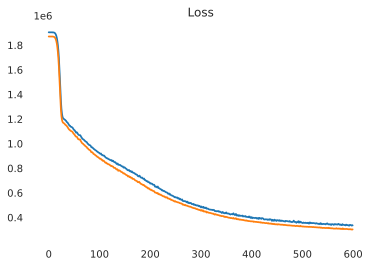

In [98]:
plt.title('Loss')
plt.plot(history.history['MAE'], label='train')
plt.plot(history.history['val_MAE'], label='test')
plt.show();

Кривая обучения получилась достаточно ровной.

In [99]:
#model.load_weights('../working/best_model.hdf5')
#model.save('../working/nn_1.hdf5')

In [100]:
test_predict_nn1 = tabular_model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.79%


In [101]:
# сохраняем сабмит
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Пробуем иную архитектуру с увеличением units, нормализацией

Simple Dense NN

In [102]:
K.clear_session()

model = Sequential()
model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
#model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="sigmoid"))
#sigmoid вместо relu ухудшила результат
model.add(L.Dropout(0.5))
#model.add(L.BatchNormalization()) #нормализация ухудшила результат
model.add(L.Dense(512, activation="relu"))
model.add(L.Dropout(0.5))
#model.add(L.BatchNormalization()) #нормализация ухудшила результат
model.add(L.Dense(1, activation="linear"))

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              515072    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 1,040,385
Trainable params: 1,040,385
Non-trainable params: 0
_________________________________________________________________


In [104]:
# компилируем модель
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [105]:
# сохраняем чекпойнты и настраиваем EarlyStopping
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [106]:
# запускаем обучение на 500 эпохах, batch_size большого размера
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

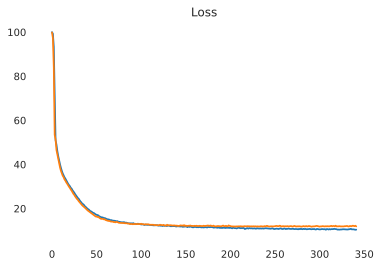

In [107]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

Кривая обучения ровная

In [108]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [109]:
test_predict_nn2 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.93%


In [110]:
sub_predict_nn2 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Вывод: создана нейронная сеть для работы с табличными данные с распределением, близким к нормальному, значительное улучшение по сравнению с наивной моделью, но хуже чем CatboostRegressor.
Настроены параметры сети (протестированы различные комбинации слоев, количества нейронов в слоях,эпох варианты batch и dropout, нормализация). Обработан признак 'mileage' - возведен в степень 0.5, извлечены числовые значения из текста:  'engine_displacement', 'engine_power', обработка признаков'transmission', 'configuration', выделено наличие 'xDrive' и '4wd' в качестве отдельных признаков.
Лучшая метрика на тестах: 11.93%

### Blend

In [111]:
blend_predict = (test_predict_catboost + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.82%


In [112]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn2[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

Вывод: применен блендинг нейронной сети и Catboost - метрика: 10.82%(лучший результат)

# Model 4: NLP + Multiple Inputs

In [113]:
# текстовое описание
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [114]:
# смотрим на самые частые слова в описании
text = ' '.join(data['description'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(50)
my_list[:20]

[(('', '', '', '', ''), 9947),
 (('-', '-', '-', '-', '-'), 1000),
 (('6', '000', 'проверенных', 'автомобилей', 'с'), 630),
 (('000', 'проверенных', 'автомобилей', 'с', 'пробегом'), 630),
 (('проверенных', 'автомобилей', 'с', 'пробегом', 'с'), 630),
 (('автомобилей', 'с', 'пробегом', 'с', 'гарантией'), 630),
 (('с', 'пробегом', 'с', 'гарантией', 'до'), 630),
 (('пробегом', 'с', 'гарантией', 'до', '2'), 630),
 (('с', 'гарантией', 'до', '2', 'лет'), 630),
 (('гарантией', 'до', '2', 'лет', 'ждут'), 630),
 (('до', '2', 'лет', 'ждут', 'Вас'), 630),
 (('2', 'лет', 'ждут', 'Вас', 'на'), 630),
 (('лет', 'ждут', 'Вас', 'на', 'сайте'), 630),
 (('ждут', 'Вас', 'на', 'сайте', 'rolf-probeg'), 630),
 (('Вас', 'на', 'сайте', 'rolf-probeg', 'и'), 630),
 (('на', 'сайте', 'rolf-probeg', 'и', 'в'), 630),
 (('сайте', 'rolf-probeg', 'и', 'в', 'мобильном'), 630),
 (('rolf-probeg', 'и', 'в', 'мобильном', 'приложении'), 630),
 (('и', 'в', 'мобильном', 'приложении', 'Мой'), 630),
 (('в', 'мобильном', 'приложен

In [115]:
# поработаем с самыми часто встречаемыми выражениями
data['description'] = data['description'].str.replace('автомобилей с пробегом','пробег')
data['description'] = data['description'].str.replace('ждут Вас на сайте','сайт')
data['description'] = data['description'].str.replace('в мобильном приложении','приложение')

In [116]:
# произведём токенизацию этого поля
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [117]:
# код для обработки русского текста, удаляем стоп-слова
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
russian_stopwords.remove('не')

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation+'«»“•' \
              and '\n' not in token]
    
    text = " ".join(tokens)
    
    return text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [119]:
data.description = data.description.apply(preprocess_text)

In [120]:
data.description

0       привет продавать эксклюзивный проект 124 униве...
1       продавать любимый тачил .. обвес тюнинг hamman...
2       машина продаваться не первый перебирать двигат...
3       автомобиль отличный состояние весь родной крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    продаваться любимый автомобиль год эксплуатаци...
8349    купить официальный дилер 2017 г третий владеле...
8350    торг место весь работать сборка немецкий резин...
8351    автомобиль отличный состояние 3 авто семья обс...
8352    удлиненный заводской pullman база w140 вообще-...
Name: description, Length: 8353, dtype: object

### Tokenizer

Создаём словарь — в Keras

In [121]:
# производим дальнейшую векторизацию текста
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.51 s, sys: 6.42 ms, total: 1.52 s
Wall time: 1.53 s


In [122]:
tokenize.word_index

{'автомобиль': 1,
 'не': 2,
 'система': 3,
 'пробег': 4,
 'задний': 5,
 'салон': 6,
 'сидение': 7,
 'весь': 8,
 'состояние': 9,
 'год': 10,
 'передний': 11,
 'машина': 12,
 'диск': 13,
 '2': 14,
 'комплект': 15,
 'дилер': 16,
 'новый': 17,
 'официальный': 18,
 'ваш': 19,
 'кредит': 20,
 'фара': 21,
 'авто': 22,
 'гарантия': 23,
 'пакет': 24,
 'руль': 25,
 'колесо': 26,
 'безопасность': 27,
 'комплектация': 28,
 '000': 29,
 'обмен': 30,
 'контроль': 31,
 'птс': 32,
 'зеркало': 33,
 'bmw': 34,
 'проверка': 35,
 'покупка': 36,
 'продажа': 37,
 'водитель': 38,
 'полный': 39,
 'шина': 40,
 'датчик': 41,
 'отличный': 42,
 'пассажир': 43,
 '1': 44,
 'двигатель': 45,
 'резина': 46,
 'владелец': 47,
 'условие': 48,
 'ключ': 49,
 'кузов': 50,
 'подушка': 51,
 'продавать': 52,
 'подогрев': 53,
 'технический': 54,
 'обогрев': 55,
 'любой': 56,
 '6': 57,
 'обслуживание': 58,
 'хороший': 59,
 'км': 60,
 'проходить': 61,
 '3': 62,
 'юридический': 63,
 'оригинал': 64,
 'стекло': 65,
 'масло': 66,
 'то

In [123]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [124]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 2.07 s, sys: 7.14 ms, total: 2.08 s
Wall time: 2.43 s


In [125]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобиль проверять 110 пункт автокредит специальный ставка 13 7 ауди центр север официальный дилер audi входить группа компания рольф являться крупный дилер европа предлагать ряд услуга покупка продажа пробег протяжение многий год наш дилерский центр являться лидер продажа пробег среди дилер audi россия предоставлять клиент самый большой выбор пробег audi марка каждый автомобиль проходить тщательный диагностика подготовка гарантировать находиться отличный состояние убеждаться правильный выбор возможность проходить тест-драйв  ―  ознакомительный поездка интересовать автомобиль смочь ознакомляться автомобиль не выходить дом  –  наш менеджер проводить online презентация видеозвонок показывать выбирать автомобиль также ауди центр север представлять уникальный предложение кредитование пробег индивидуальный условие специалист компания подбирать хороший условие кредитование 6 000 проверять пробег гарантия 2 год сайт rolf probeg приложение рольф
[   0    0    0    0    0    0    0    0    0 

### RNN NLP

In [126]:
# строим сеть для обработки текста
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [127]:
# добавим ещё одну сеть для табличных данных
model_mlp = Sequential()
model_mlp.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(512, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [128]:
# объединяем сети в Multi-Input 
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [129]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     5756160     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [130]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [131]:
# настраиваем показатели, чекпойнты, EarlyStopping
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [132]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 348ms/step - loss: 99.9225 - MAPE: 99.9225 - val_loss: 99.0022 - val_MAPE: 99.0022
Epoch 2/500
12/12 [==============================] - 3s 269ms/step - loss: 90.7664 - MAPE: 90.7664 - val_loss: 60.5359 - val_MAPE: 60.5359
Epoch 3/500
12/12 [==============================] - 3s 266ms/step - loss: 55.1154 - MAPE: 55.1154 - val_loss: 47.8518 - val_MAPE: 47.8518
Epoch 4/500
12/12 [==============================] - 3s 275ms/step - loss: 47.3043 - MAPE: 47.3043 - val_loss: 43.5414 - val_MAPE: 43.5414
Epoch 5/500
12/12 [==============================] - 3s 264ms/step - loss: 42.5733 - MAPE: 42.5733 - val_loss: 40.4525 - val_MAPE: 40.4525
Epoch 6/500
12/12 [==============================] - 3s 265ms/step - loss: 38.9956 - MAPE: 38.9956 - val_loss: 36.5793 - val_MAPE: 36.5793
Epoch 7/500
12/12 [==============================] - 4s 297ms/step - loss: 36.2069 - MAPE: 36.2069 - val_loss: 34.5868 - val_MAPE: 34.5868
Epoch 8/500
12/12 [========

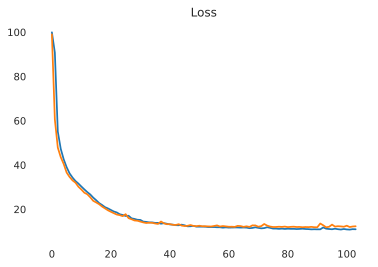

In [133]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [134]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [135]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.32%


Показатель ошибки TEST mape: 12.32% стал немного выше, это связано с недостаточной обработкой текста перед реализацией модели.

In [137]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

### LSTM

Строим рекуррентную нейронную сеть для обработки последовательности векторов с использованием слоя LSTM.

In [136]:
%%time
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(test['description'])

CPU times: user 414 ms, sys: 3.53 ms, total: 418 ms
Wall time: 423 ms


In [138]:
lstm_nlp = Sequential(name='LSTM')
lstm_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
lstm_nlp.add(L.Embedding(len(tokenizer.word_index)+1, MAX_SEQUENCE_LENGTH,))
lstm_nlp.add(L.LSTM(350, return_sequences=True))
lstm_nlp.add(L.Dropout(0.5))
lstm_nlp.add(L.LSTM(256,))
lstm_nlp.add(L.Dropout(0.25))
lstm_nlp.add(L.Dense(256, activation="relu"))
lstm_nlp.add(L.Dropout(0.25))

nlp_model = Sequential()
nlp_model.add(lstm_nlp)
nlp_model.add(L.Dense(64, activation='relu'))
nlp_model.add(L.Dense(1, activation='linear'))

In [139]:
checkpoint = ModelCheckpoint('../working/best_nlp_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
callbacks_list = [checkpoint]

In [ ]:
# обучаем модель без табличных данных
LR = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
nlp_model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAE'])


history = nlp_model.fit(text_train_sequences, y_train,
                        batch_size=128,
                        epochs=12,
                        validation_data=(text_test_sequences, y_test),
                        callbacks=callbacks_list
                       )

Вывод: построена NLP модель для обработки тестовых описаний автомобиля, создан алгоритм очистки и аугментации текста, выделены часто встречающиеся блоки текста, заменив их на кодовые слова, сделана лемматизация и стеммниг. Данные NLP модели и NN модели объеденены в multiple inputs сеть.После обработки текстов описаний удалось улучшить метрику по сравнению с наивной моделью - показатель МАРЕ: 12.32%.

# Model 5: Добавляем картинки

### Data

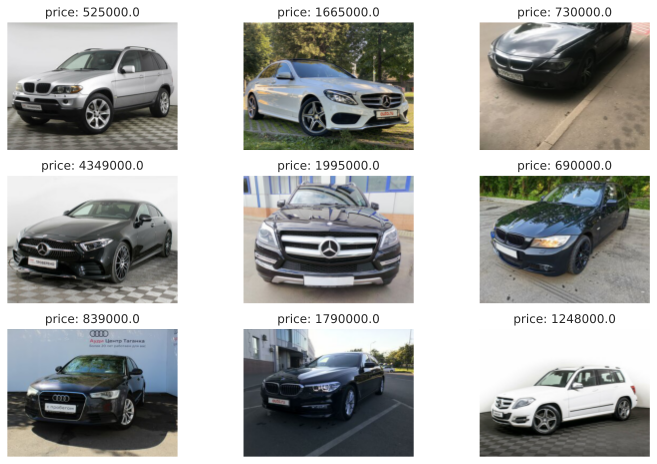

In [142]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [143]:
# подгрузим картинки в память и создадим матрицу
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


In [144]:
# делаем аугментацию картинок
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,  
    Rotate, CenterCrop, GaussianBlur,RGBShift, FancyPCA, Resize,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [145]:
# аугментация
augmentation = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          always_apply=False, p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.7),
    albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.7),
    albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20,
                            b_shift_limit=20, always_apply=False, p=0.7),
    albumentations.ChannelShuffle(p=0.7),
    albumentations.CLAHE(clip_limit=3.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.3)
])

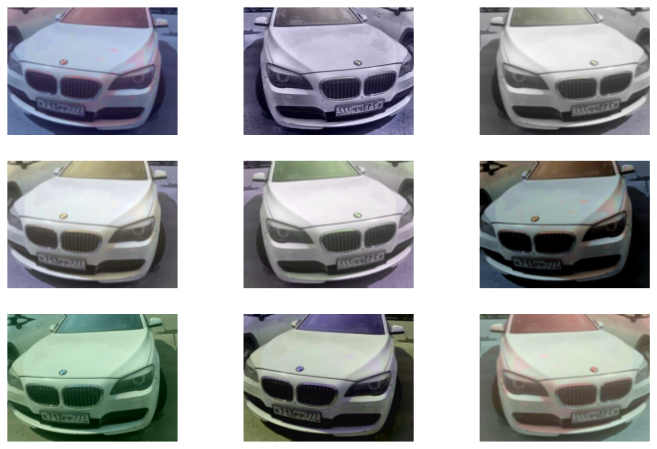

In [146]:
# смотрим, что получилось
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [147]:
# функция для аугментации
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [148]:
# NLP 
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [149]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions),
                                  maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)


test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)


y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)


#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [150]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [151]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [152]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [153]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [154]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [155]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [156]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 131s 690ms/step - loss: 54.4515 - MAPE: 54.4515 - val_loss: 35.6756 - val_MAPE: 35.6756
Epoch 2/100
190/190 [==============================] - 127s 667ms/step - loss: 32.7716 - MAPE: 32.7716 - val_loss: 29.2500 - val_MAPE: 29.2500
Epoch 3/100
190/190 [==============================] - 125s 660ms/step - loss: 26.5363 - MAPE: 26.5363 - val_loss: 23.6525 - val_MAPE: 23.6525
Epoch 4/100
190/190 [==============================] - 126s 661ms/step - loss: 21.4571 - MAPE: 21.4571 - val_loss: 20.2012 - val_MAPE: 20.2012
Epoch 5/100
190/190 [==============================] - 126s 661ms/step - loss: 18.7029 - MAPE: 18.7029 - val_loss: 16.2498 - val_MAPE: 16.2498
Epoch 6/100
190/190 [==============================] - 125s 660ms/step - loss: 17.1623 - MAPE: 17.1623 - val_loss: 14.8058 - val_MAPE: 14.8058
Epoch 7/100
190/190 [==============================] - 125s 657ms/step - loss: 15.8848 - MAPE: 15.8848 - val_loss: 14.0464 - val_MAPE: 14.0464

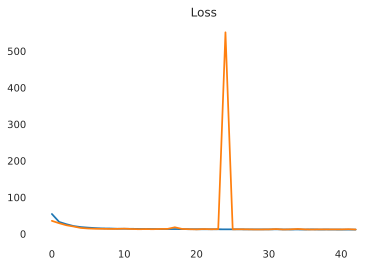

In [157]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

кривая имеет явное отклонение

In [158]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [159]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.07%


In [160]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

Вывод: построена СV модель для обработки изображений, данные СV модели, NLP модели и NN модели объеденены в multiple inputs сеть. С помощью обработки изображений удалось улучшить метрику по сравнению с наивной моделью - TEST mape: 12.07%

## Fine-tuning

In [163]:
# добавим политику на LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(0.005)

# компилируем модель
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [164]:
checkpoint = ModelCheckpoint('../working/best_img_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')

earlystop = EarlyStopping(monitor='val_MAE', patience=4, restore_best_weights=True,)

#callbacks_list = [reduce_lr, checkpoint, earlystop]
callbacks_list = [checkpoint, earlystop]

In [165]:
# проверяем на 10 эпохах
history = model.fit(train_dataset.batch(5),
                    epochs=10,
                    validation_data = test_dataset.batch(5),
                    callbacks=callbacks_list
                   )

Epoch 1/10
1136/1136 [==============================] - 221s 195ms/step - loss: 13.0298 - MAPE: 13.0298 - val_loss: 13.4018 - val_MAPE: 13.4018
Epoch 2/10
1136/1136 [==============================] - 218s 192ms/step - loss: 13.5568 - MAPE: 13.5568 - val_loss: 12.5266 - val_MAPE: 12.5266
Epoch 3/10
1136/1136 [==============================] - 218s 192ms/step - loss: 13.6540 - MAPE: 13.6540 - val_loss: 12.5165 - val_MAPE: 12.5165
Epoch 4/10
1136/1136 [==============================] - 217s 191ms/step - loss: 13.7297 - MAPE: 13.7297 - val_loss: 13.9270 - val_MAPE: 13.9270
Epoch 5/10
1136/1136 [==============================] - 216s 190ms/step - loss: 13.3561 - MAPE: 13.3561 - val_loss: 12.7300 - val_MAPE: 12.7300
Epoch 6/10
1136/1136 [==============================] - 218s 192ms/step - loss: 13.3259 - MAPE: 13.3259 - val_loss: 12.5531 - val_MAPE: 12.5531
Epoch 7/10
1136/1136 [==============================] - 218s 192ms/step - loss: 13.3087 - MAPE: 13.3087 - val_loss: 12.1589 - val_MAPE: 

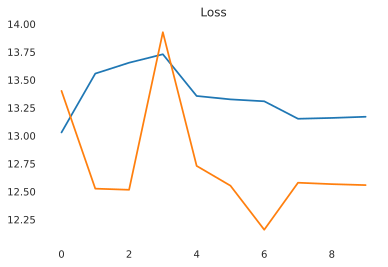

In [166]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [167]:

model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [168]:
test_predict_nn4 = model.predict(test_dataset.batch(35))
print(f"TEST mape: {(mape(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

TEST mape: 12.07%


In [169]:
sub_predict_nn4 = model.predict(sub_dataset.batch(35))
sample_submission['price'] = sub_predict_nn4[:, 0]
sample_submission.to_csv('nn4_submission.csv', index=False)

Вывод: fine-tuning не дал улучшения показателя модели, модель недообучилась, нужно увеличить количество эпох

# Blend

In [179]:
# пробуем различные варианты бленда 
blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn1[:,0]) / 3
print(f"TEST mape with nn1: {(mape(y_test, blend_predict))*100:0.2f}%")

blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn_bonus[:,0]) / 3
print(f"TEST mape with bonus: {(mape(y_test, blend_predict))*100:0.2f}%")

blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn1[:,0]+ test_predict_nn1[:,0]) / 4
print(f"TEST mape with nn1, nn2: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape with nn1: 11.15%
TEST mape with bonus: 10.93%
TEST mape with nn1, nn2: 11.43%


Вывод: попробовали различные варианты блендинга моделей, лучший результат остался у Catboost и простой нейронной сети - метрика: 10.82%

# Model Bonus: проброс признака

In [161]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [170]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.production_date.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [171]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [172]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_16_input (InputLayer)     [(None, 502)]        0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 512)          257536      dense_16_input[0][0]             
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 512)          0           dense_16[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [173]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [174]:
history = model.fit([X_train, X_train.production_date.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.production_date.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 30ms/step - loss: 99.9742 - MAPE: 99.9742 - val_loss: 99.7060 - val_MAPE: 99.7060
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 97.5331 - MAPE: 97.5331 - val_loss: 89.1615 - val_MAPE: 89.1615
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 69.6197 - MAPE: 69.6197 - val_loss: 52.2085 - val_MAPE: 52.2085
Epoch 4/500
12/12 [==============================] - 0s 9ms/step - loss: 52.3660 - MAPE: 52.3660 - val_loss: 47.2245 - val_MAPE: 47.2245
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 46.6521 - MAPE: 46.6521 - val_loss: 43.6757 - val_MAPE: 43.6757
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 42.7972 - MAPE: 42.7972 - val_loss: 40.6103 - val_MAPE: 40.6103
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 39.9496 - MAPE: 39.9496 - val_loss: 37.9551 - val_MAPE: 37.9551
Epoch 8/500
12/12 [=====================

In [ ]:
model.load_weights('../working/best_model.hdf5')

In [176]:
test_predict_nn_bonus = model.predict([X_test, X_test.production_date.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 11.91%


In [178]:
sub_predict_nn_bonus = model.predict([X_sub, X_sub.production_date.values])
sample_submission['price'] = sub_predict_nn_bonus[:,0]
sample_submission.to_csv('predict_nn_bonus_submission.csv', index=False)

In [180]:
# blend_predict = (test_predict_catboost + test_predict_nn_bonus[:,0]+ test_predict_nn2[:,0]) / 4
# print(f"TEST mape with nn2, nn_bonus: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape with nn2, nn_bonus: 26.82%


Вывод: сделана модель с пробросом признаков (1/2 признака) с различными настройками сети (количество слоев, нейронов в слое, LR). Точность модели по метрике TEST mape: 11.91%
Блендинг с этой моделью показал отрицательный результат и ухудшил модель до 26.82%

##  Выводы

* Проведен детальный анализ и очистка признаков, признаки обрабатывала по-разному проверяла изменения; сгенерированы новые признаки 'rolf','dealer','airbag','warranty','child_car_seat','power_windows','central_lock','seat_heating','4wd','xdrive','power_per_volume'(многие были удалены из-за сильной корреляции с уже имеющимися в датасете, модель переобучалась, например, 'mileage_owner','car_age','mile_per_year', 'mileage_category');проведена оценка значимости признаков, удалены признаки с нулевой значимостью. Извлечены числовые значения из столбцов 'engine_displacement' и 'engine_power'. В 'description' и  'configuration' проведена очистка текста, удаление стоп-слов и спец символов, выявление часто встречающихся выражений; сократила размерности признака 'name' за счет удаленных данных, дублирующихся в других столбцах, например, преобразованы значения в столбце 'transmission', токенизация признака 'configuration' для NLP и сделаны dummies для основных значений; проведена нормализация и логарифмирование числовых признаков, признак 'mileage' - возведен в степень 0.5, обрабатывался логарифм от целевой переменной, а на предикте бралась экспанента.

* Построена модель CatBoostRegressor, TEST mape:11.38%, достигнуто с помощью обработки имеющихся и добавления новых признаков. Подбор гиперпараметров  для CatBoostRegressor  {'depth': 11, 'l2_leaf_reg': 8, 'random_strength': 0.2, 'learning_rate': 0.15}улучшения не дал, точность по метрике: 11.61%.

* Построена Simple Dense NN -сеть из трёх слоёв с дропаутами, значительное улучшение по сравнению с наивной моделью, но хуже чем CatboostRegressor, точность по метрике MAPE:12.79%. Настроены параметры сети (протестированы различные комбинации слоев, количества нейронов в слоях,эпох, варианты batch, dropout, нормализация). Лучшая метрика на тестах: 11.93%

* Применен блендинг нейронной сети nn2 и Catboost - метрика: 10.82%(лучший результат).

* Построена NLP модель для обработки тестовых описаний автомобиля, создан алгоритм очистки и аугментации текста, выделены часто встречающиеся блоки текста, заменив их на кодовые слова, сделана лемматизация и стеммниг. В Multi-Input сеть объединили сеть для обработки тестовых описаний и сеть для табличных данных. После обработки текстов описаний удалось улучшить метрику по сравнению с наивной моделью - показатель МАРЕ: 12.32%.

* Построена СV модель для обработки изображений, данные СV модели, NLP модели и NN модели объеденены в multiple inputs сеть, проведены различные аугментации. С помощью обработки изображений удалось улучшить метрику по сравнению с наивной моделью - TEST mape: 12.07%, fine-tuning не дал улучшения показателя модели, модель недообучилась, нужно увеличить количество эпох

* Попробовали различные варианты блендинга моделей, лучший результат остался у Catboost и простой нейронной сети - метрика: 10.82%

* Сделана модель с пробросом признаков (1/2 признака) с различными настройками сети (количество слоев, нейронов в слое, LR). Точность модели по метрике TEST mape: 11.91%.

* Итоговый результат на Kaggle - 11.24% (22 место)

* Что можно улучшить: потратить больше времени на ТЕСТИРОВАНИЕ различных архитектур, усложнить Fine-tuning, лучше и основательнее обработать NLP часть, вытащить больше кодовых слов, иная предобработка данных и обогощение датасета и их взаимосвязь с построением моделей. 